## Using K-NN regression to predict play time on a MineCraft server ##

### Introduction ###
This project examines data from a MineCraft server collected from a research group in Computer Science at UBC led by Frank Wood to investigate how people play video games. The research group is interested in targeting their recruitment efforts and making sure they have all the necessary resources to run the server. This project will address what types of players are most likely to contribute a large amount of data so that recruiting efforts can be targeted towards those groups. Specifically, this project will analyze if user age can predict their play time in MineCraft in the players.csv dataset. The players.csv dataset includes a list of all unique players on the MineCraft server and contains data about each player. There are 196 observations and 7 variables in the players.csv dataset.

****Data Description: Players.csv data (196 observations x 7 variables)****

- `subscribe`: True/False, if the user is subscribed to the game-related newsletter
- `name`: The user's name
- `age`:  The user's age
- `gender`: The user's gender
- `hours_played`: Total hours played on the server
- `experience`: Experience level from Beginner, Amateur, Regular, Pro, Veteran
- `hashedEmail`: An encrypted email


### Methods & Results ###
K-nearest neighbors regression is used to address if age can predict playing time. This model suits the data well because there does not appear to be any linear trends within the data, and we are predicting a numerical value using a numerical predictor, therefore KNN regression fits these parameters the best. 

To begin, the data will be loaded, wrangled, and cleaned to include only the necessary information for our analysis, the age and total hours played columns.
To process the data it will be split into a training and testing set before applying any processing steps, with 70% of the data in the training set and 30% in the testing set. Even though there is only one predictor variable, the data will still be standardized so that values are on a more balanced scale that is less sensitive to large values and outliers. Missing values will be removed as there are only 2 values missing from the Age variable. Next, the model will be trained with the training set, cross validation with 5 folds will be used to find the optimal K for the model, and RMSE can be used to determine the strength of the model. The model will then be evaluated using the testing set and its performance will be analyzed using regression metrics such as RMSPE. 

In [2]:
# Load libraries
library(tidyverse)
library(repr)
library(tidymodels)

# Set seed
set.seed(2025)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

****Data Cleaning and Filtering****

We first remove observations with missing values in the Age column to ensure a complete dataset for training and evaluation. Since only two values are missing, this approach avoids errors and prevents skew without major data loss.

In [3]:
# Load dataset
players <- read_csv("https://raw.githubusercontent.com/ckmidas/dsci100-project-proposal/refs/heads/main/players.csv") |>
    filter(!is.na(Age)) # Remove observations with missing ages
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


****Data Splitting****

We split the data into 70% training and 30% testing, making sure that both sets have a similar range of played_hours values. This helps us get a fair evaluation by keeping the response variable's distribution consistent in both sets.

In [29]:
# Split data into training and testing sets
players_split <- initial_split(players, prop = 0.7, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

****Recipe Creation****

We standardized the predictor Age using centering and scaling so that it's on the same scale as other values. This is important for K-NN because it measures distance, and large values could otherwise dominate the results.

In [30]:
# Define recipe
players_recipe <- recipe(played_hours ~ Age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

****Model Tuning****

To determine the best number of neighbors (k) for our K-NN regression model, we set up a grid of possible values ranging from 1 to 20. We then performed 5-fold cross-validation on the training set, which helps us assess model performance more reliably by training and validating on different parts of the data. We used RMSE (Root Mean Squared Error) as the metric to choose the best k, since it measures prediction error in the same units as the response variable (played hours) and is sensitive to larger errors.

In [46]:
# Run cross-validation
gridvals = tibble(neighbors = seq(from = 1, to = 20, by = 1))

tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_min <- workflow() |>
    add_model(tune_spec) |>
    add_recipe(players_recipe) |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    slice_min(mean)
players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
14,rmse,standard,32.50494,5,5.807859,Preprocessor1_Model14


****Train final model and evaluate on test set****

After identifying the value of k that resulted in the lowest RMSE, we used this optimal k to finalize our K-NN model. We then trained the model using the full training set. Once the model was trained, we evaluated it on the test set to measure how well it generalized to unseen data. 

In [47]:
# Test model
k_min <- pull(players_min, neighbors)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("regression")

players_fit <- workflow() |>
    add_model(players_spec) |>
    add_recipe(players_recipe) |>
    fit(data = players_training)

players_summary <- players_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) |>
    metrics(truth = played_hours, estimate = .pred)
players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.565594126
rsq,standard,0.008002457
mae,standard,4.527500000


****Model Fit Visualization****

To wrap up the analysis, we created a plot showing how the model's predictions compare to the actual play time values across different ages. This helps us visually check how well the model captured patterns in the data and spot where it might be over- or under-estimating.

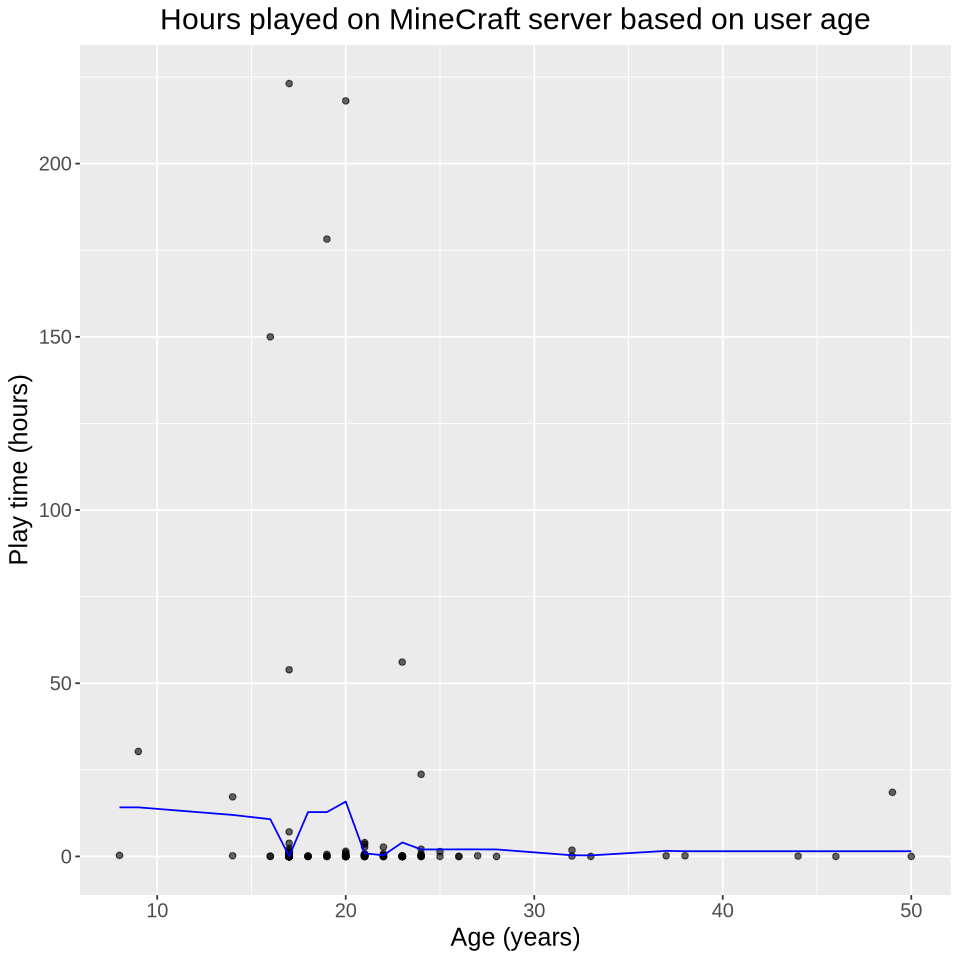

In [49]:
# Plot model fit
options(repr.plot.width = 8, repr.plot.height = 8)

players_preds <- predict(players_fit, players_training) |>
    bind_cols(players_training)

players_plot <- players_preds |>
    ggplot(aes(x = Age, y = played_hours)) +
        geom_point(alpha = 0.6) +
        geom_line(aes(x = Age, y = .pred), color = "blue") +
        labs(x = "Age (years)", y = "Play time (hours)") +
        ggtitle("Hours played on MineCraft server based on user age") +
        theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))
players_plot

**Figure 3:** Play time predicted by our KNN regression model based on player age compared to actual values.

### Discussion

With our project, we sought to see if we could predict a player’s play time on a MineCraft server based on their age. In the exploratory phase, we observed that younger players had higher play times, suggesting a potential trend to inform a KNN regression model. In the tuning phase, five-fold cross validation found that the optimal K was 14 neighbours, with a mean RMSE of 32.50 ± 5.81. When assessing performance on unseen data, our optimized model had a RMSPE of 9.57, suggesting decent accuracy. Our final KNN regression model predicts that younger players, especially those between 8–16 years old or 18–20 years old, are more likely to have higher play times. Interestingly, our model predicted low play times for players who were 17 years old, likely due to the high number of players that age with little to no play time. All players aged 21 years or older had low play times.

Overall, the results partially matched what we expected. We anticipated that younger players would generally have more time and interest to play Minecraft, which the model confirmed to some extent, especially for those between 8–16 and 18–20 years old. However, we didn’t expect such a sharp drop for players who were 17 years old. That result was surprising, and it reflects something specific about the data distribution, like many 17 year olds who registered but didn’t actually play. We also expected play time to gradually decrease with age, which mostly held true, though the pattern wasn’t perfectly smooth. Another unexpected finding was the large number of players who had exactly 0 hours of play time. This was especially clear from our scatterplot. We had assumed most players in the dataset had at least some level of activity, so the prevalence of zero values made it harder for the model to detect clear trends and may have reduced its overall predictive performance.